# CMA-ES algorithm

Imports

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Ellipse
import matplotlib.transforms as transforms
import jax.numpy as jnp
from jax import jit, vmap
from jax.random import normal, uniform, PRNGKey, split

Define the confidence ellipse and a set of 2D function that can be optimized numerically using the CMA-ES algorithm.

In [2]:
def confidence_ellipse(mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
    pearson = cov[0, 1]/jnp.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = jnp.sqrt(1 + pearson)
    ell_radius_y = jnp.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # rescale
    scale_x = jnp.sqrt(cov[0, 0]) * n_std
    scale_y = jnp.sqrt(cov[1, 1]) * n_std

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean[0], mean[1])

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)
    

def rosenbrock(x, y, a=1, b=100):
    return (a-x)**2 + b*(y-x**2)**2

def func(x, y):
    return (jnp.abs(x - 3) + jnp.abs(y - 1))

def goldsteinprice(x1, x2):
    return (1 + (x1 + x2 + 1)**2 * (19 - 14 * x1 + 3 * x1**2 - 14 * x2 + 6 * x1 * x2 + 3 * x2**2)) * (
            30 + (2 * x1 - 3 * x2)**2 * (18 - 32 * x1 + 12 * x1**2 + 48 * x2 - 36 * x1 * x2 + 27 * x2**2)) - 3
def branin(x, y):
    return (y - 5.1 * x**2 / 4 / jnp.pi**2 + 5 * x / jnp.pi - 6)**2 + 10 * (1 - 1 / 8 / jnp.pi) * jnp.cos(x) + 10 - 0.397887357729738160000

def paraboloid(x, y, a=1, b=1):
    return (x-a)**2 + (y-b)**2 + (z-c)**2


Select one of the function and visualize the function value f(x, y) as a heatmap.

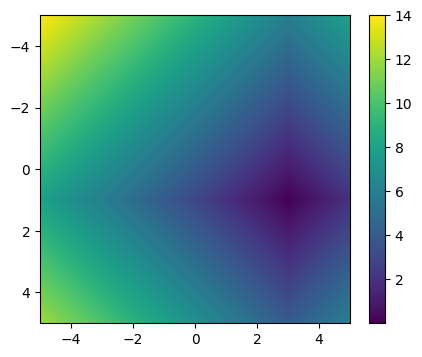

In [3]:
search_space_range = [-5, 5]
s = jnp.linspace(search_space_range[0], search_space_range[1], 256)
x, y = jnp.meshgrid(s, s)

f = lambda x, y: func(x, y) # pick here your function to evaluate
Z = f(x, y)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
im = ax.imshow(Z, aspect='auto', extent=[jnp.min(s), jnp.max(s), jnp.max(s), jnp.min(s)])
fig.colorbar(im)
plt.show()

Initialize hyperparameters according to Hansen 2016, and create functions within the CMA-ES algorithm where we can apply the jit transformation to.

In [4]:
key = PRNGKey(0)
key, subkey = split(key)

n = 2 # 2 dimensional problem
threshold = 1e-3 # stop when dm < threshold, we can also use dfunction value or dC
max_g = 100 # max generation 

# Set hyperparameters according to Hansen 2016

λ = int(4 + 3 * jnp.log(n))
μ = λ//2
σ = 0.5

w = jnp.log((λ+1)/2) - jnp.log(jnp.arange(λ) + 1)
w = w.at[:μ].set(w[:μ] / sum(w[:μ])) # positive weights sum to 1
μeff = jnp.sum(w[:μ])**2/jnp.sum(w[:μ]**2) # ratio between the L1-norm squared and L2-norm of recombination weights

cm = 1
cσ = (μeff + 2) / (n + μeff + 5)
dσ = 1 + 2 * max(0, jnp.sqrt((μeff - 1) / (n + 1)) - 1) + cσ
cc = (4 + μeff / n) / (n + 4 + 2 * μeff/n)
c1 = 2 / ((n + 1.3)**2 + μeff)
cμ = min(1-c1, 2 * (1/4 + μeff + 1/μeff -2) / ((n+2)**2 + μeff))


min_alpha = min(
    1 + c1 / cμ,  # eq.50
    1 + (2 * (jnp.sum(w[μ:]) ** 2 / jnp.sum(w[μ:] ** 2))) / (μeff + 2),  # eq.51
    (1 - c1 - cμ) / (n * cμ),  # eq.52
)
w = w.at[μ:].set(-min_alpha / sum(w[μ:]) * w[μ:]) # negative weights sum to -min_alpha

eln = jnp.sqrt(n) * (1 - 1/(4*n) + 1/(21*n**2)) # expected length multivariate standard normal distribution
h_const = (1.4 + 2/(n+1)) * eln

@jit
def rescale_samples(z, B, D, xm, σ):
    y = jnp.matmul(B, D*z)
    x = xm + σ * y  
    return x, y

@jit
def select_and_recombine(x, y, z, w, xm, cm, σ):
    zm = jnp.sum(w * z, 0)
    ym = jnp.sum(w * y, 0)
    xm_old = xm
    xm += cm * σ * ym
    dxm = xm - xm_old
    return xm, ym, zm, dxm

@jit
def update_pσ(pσ, B, zm, μeff, cσ):
    pσ = (1-cσ) * pσ + jnp.sqrt(cσ * (2-cσ) * μeff) * jnp.matmul(B, zm) # * jnp.matmul(invsqrtC, ym)
    norm_pσ = jnp.linalg.norm(pσ)
    return pσ, norm_pσ

@jit
def update_pc(pc, ym, μeff, hσ, cc):
    return (1-cc) * pc + hσ * jnp.sqrt(cc * (2-cc) * μeff) * ym

@jit 
def heaviside(norm_pσ, g, cσ, cc, h_const):
    hσ = 1.0 * (norm_pσ/jnp.sqrt(1-(1-cσ)**(2*(g+1))) < h_const)
    dhσ = (1-hσ) * cc *(2-cc)
    return hσ, dhσ
    
@jit 
def ddc(w, z, B, n): # directional dependent constant
    return n /(jnp.linalg.norm(jnp.matmul(z, B) , axis=1)**2)

@jit
def update_σ(σ, pσ, norm_pσ, eln, cσ, dσ):
    return σ * jnp.exp((cσ/dσ) * (norm_pσ / eln - 1))

@jit
def update_C(C, pc, y, w, w0, c1, cμ):
    C = (1 + c1 * dhσ - c1 - cμ * jnp.sum(w)) * C \
        + c1 * jnp.outer(pc, pc) \
        + cμ * jnp.matmul(y.T, w0 * y)
    return C

The CMA-ES parameter initialization and the generation loop.

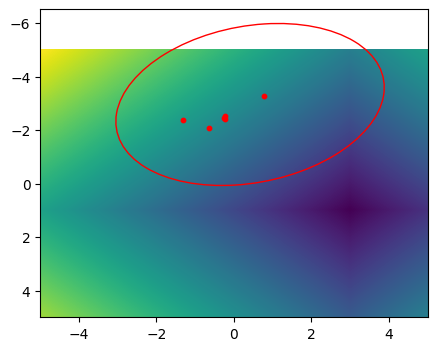

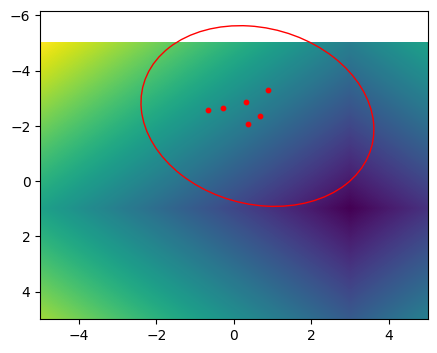

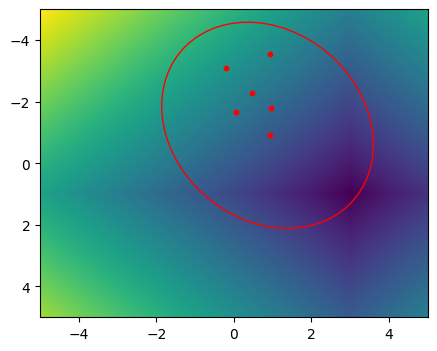

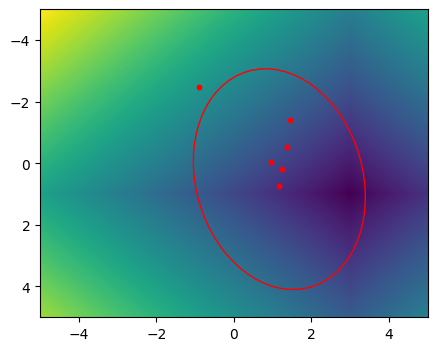

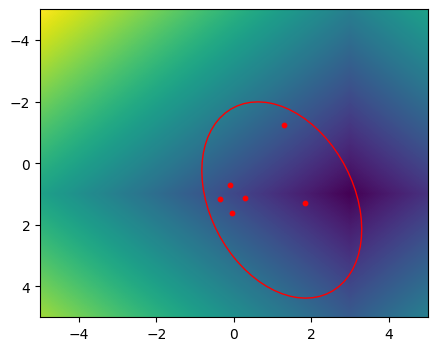

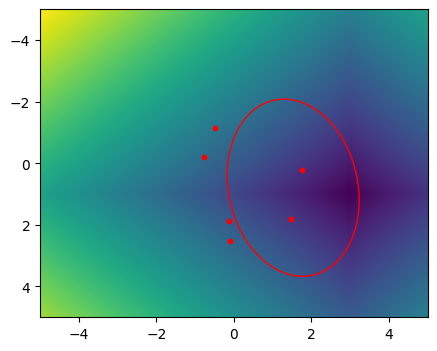

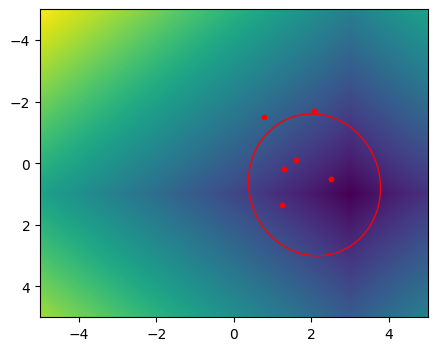

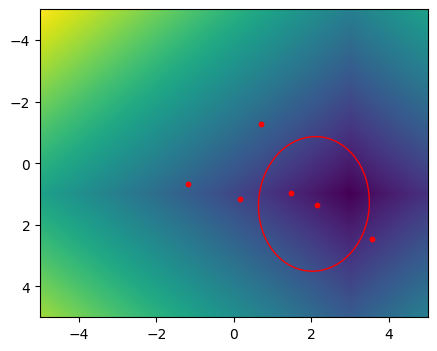

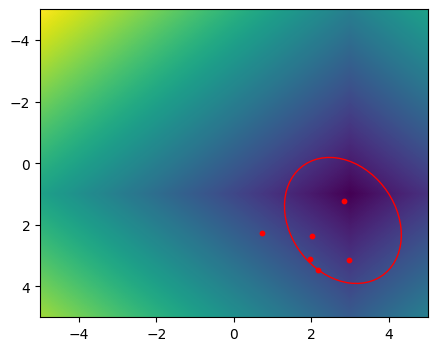

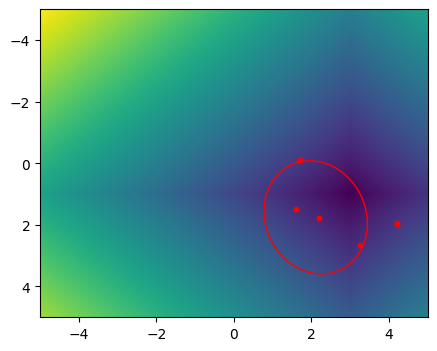

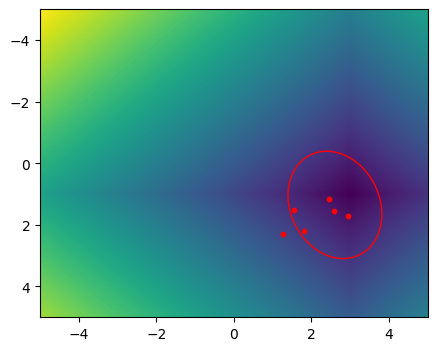

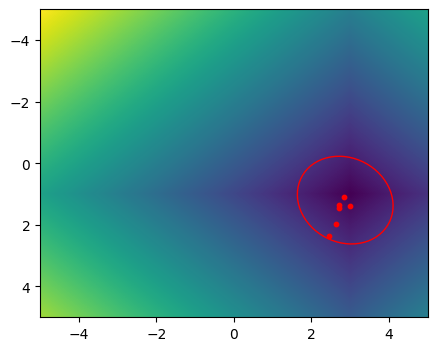

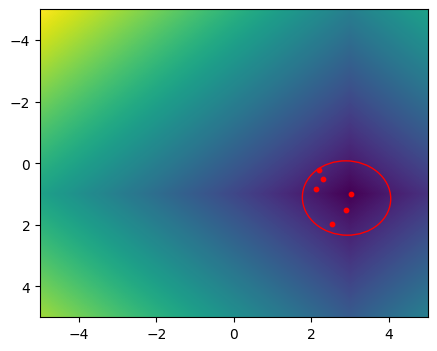

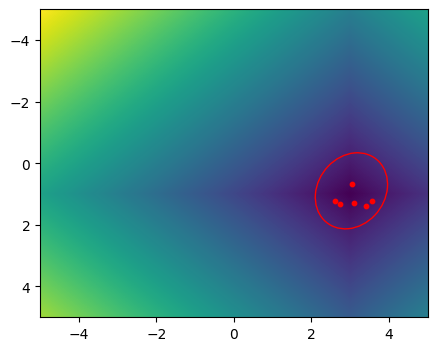

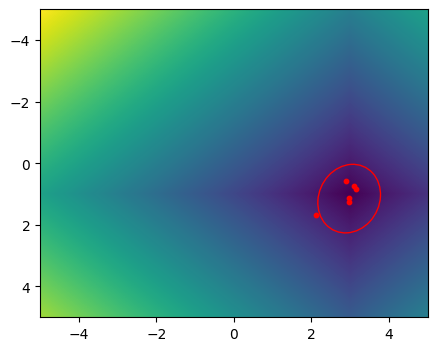

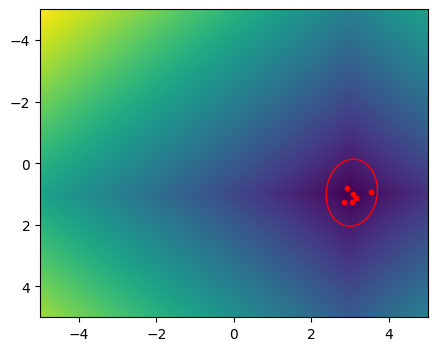

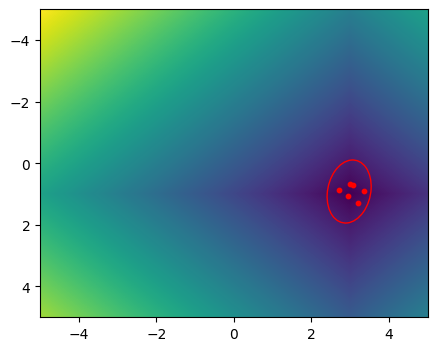

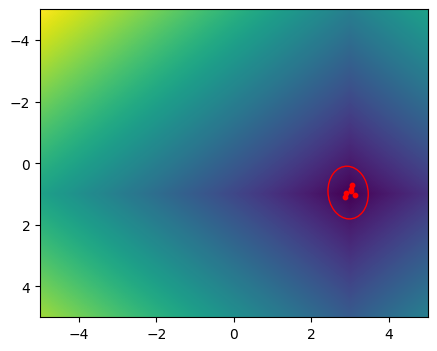

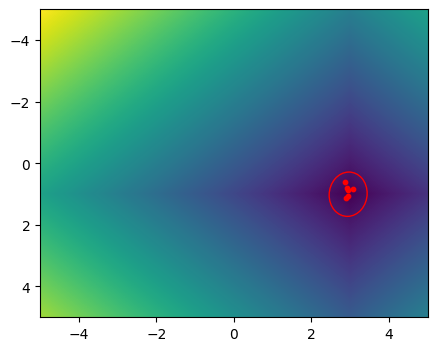

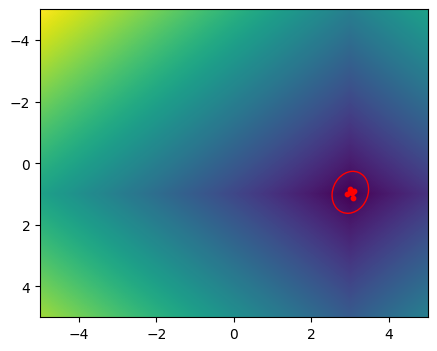

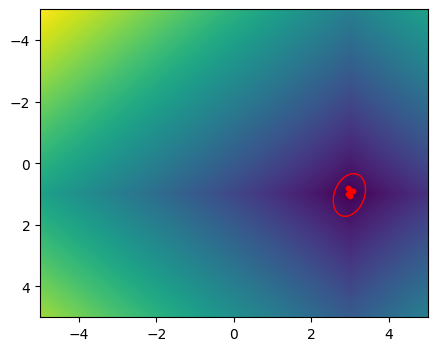

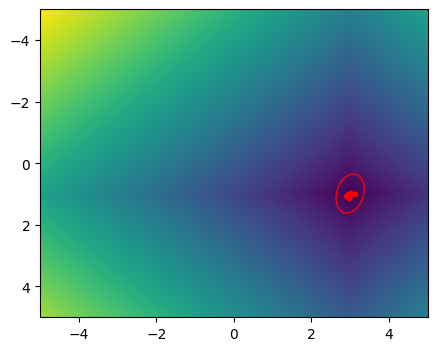

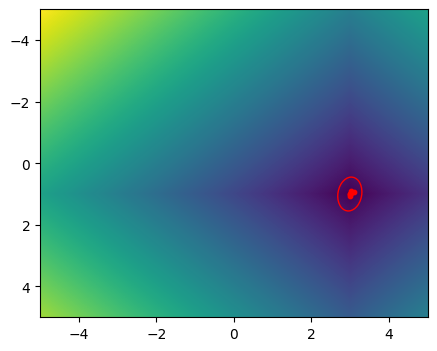

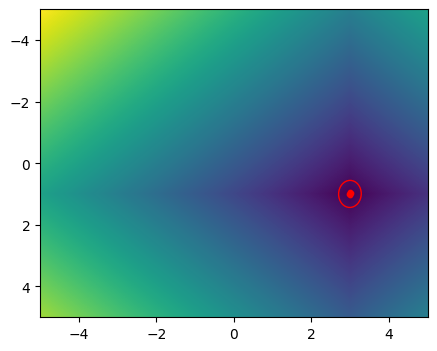

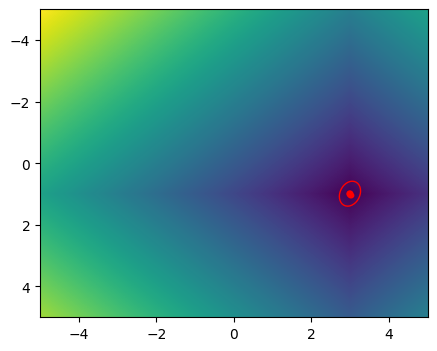

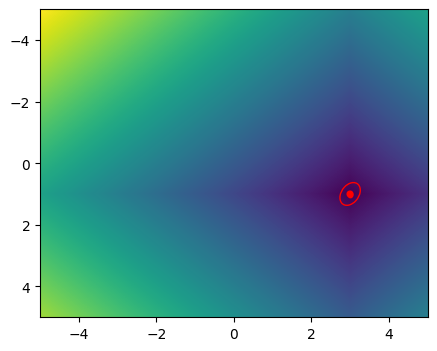

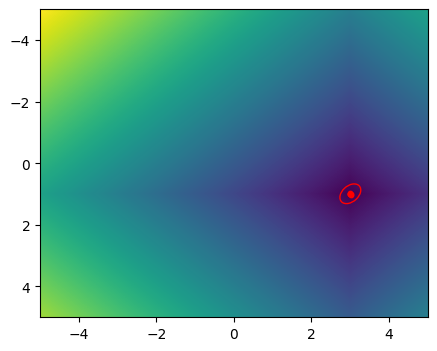

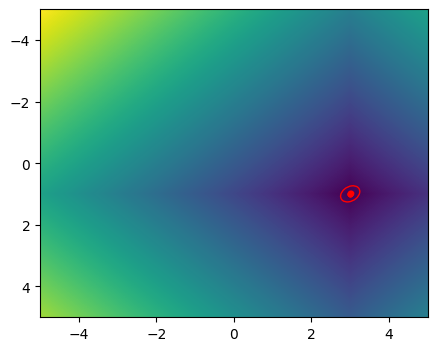

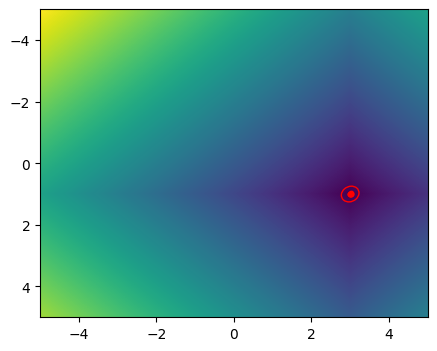

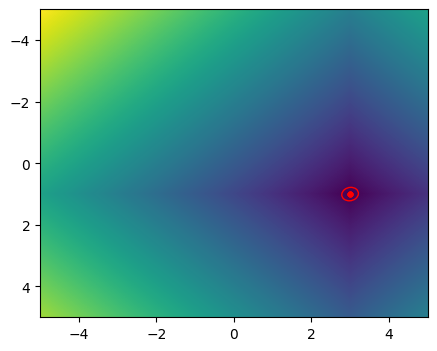

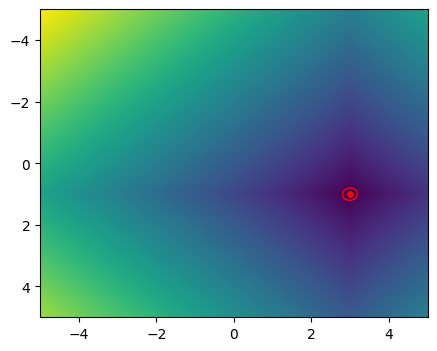

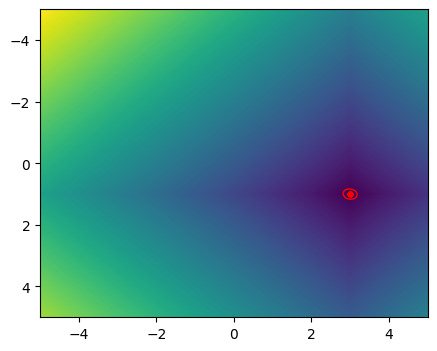

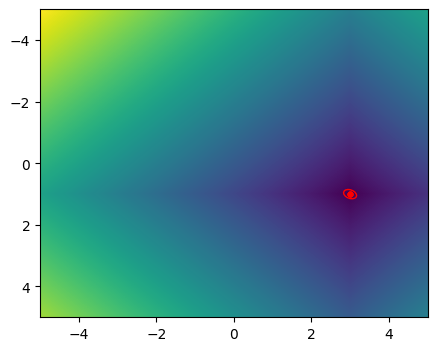

In [5]:
# initialize parameters
pσ = jnp.zeros(n)
pc = jnp.zeros(n)
xm = uniform(key=key, shape=(n,)) * (search_space_range[1] - search_space_range[0]) + search_space_range[0]
dxm = 1
C = jnp.eye(n) 
D, B = jnp.linalg.eigh(C)
D = jnp.sqrt(D)
#invsqrtC = jnp.matmul(B, jnp.matmul(jnp.diag(1/D), B.T))
g = 0
res = []

while jnp.sum(jnp.abs(dxm) > threshold) > 0:
    key, subkey = split(key)
    g += 1

    # Generate samples
    z = normal(key=key, shape=(λ, n))
    x, y = vmap(rescale_samples, in_axes=(0, None, None, None, None))(z, B, D, xm, σ)
    
    # Sort, Select and recombine
    idx_sort = jnp.argsort(f(x[:, 0], x[:, 1])) 
    x, y, z = x[idx_sort, :], y[idx_sort, :], z[idx_sort, :]    
    xm, ym, zm, dxm = select_and_recombine(x[:μ, :], y[:μ, :], z[:μ, :], w[:μ, None], xm, cm, σ)
    res += [f(xm[0], xm[1])]
    
    # Update evolution paths
    pσ, norm_pσ = update_pσ(pσ, B, zm, μeff, cσ)
    hσ, dhσ = heaviside(norm_pσ, g, cσ, cc, h_const) #hσ stalls the update of pc if norm(pσ) is large
    pc = update_pc(pc, ym, μeff, hσ, cc)
    
    # Update Covariance matrix and step-size
    w0 = w.copy()
    w0 = w0.at[w0 < 0].set(w0[w0 < 0] * ddc([w0 < 0], z[w0 < 0, :], B, n))
    
    C = update_C(C, pc, y, w, w0[:, None], c1, cμ)
    σ = update_σ(σ, pσ, norm_pσ, eln, cσ, dσ)
    
    C = jnp.triu(C) + jnp.triu(C, 1).T # make sure C is symmetric
    D, B = jnp.linalg.eigh(C)
    D = jnp.sqrt(jnp.abs(D))
    #invsqrtC = jnp.matmul(B, jnp.matmul(jnp.diag(1/D), B.T))
    
    # Plot samples    
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    ax.imshow(Z, aspect='auto', extent=[jnp.min(s), jnp.max(s), jnp.max(s), jnp.min(s)])
    confidence_ellipse(mean=xm, cov=C, ax=ax, edgecolor='red')
    ax.scatter(x[:, 0], x[:, 1], s=10, color='red')
    plt.show()
    
    if g > max_g:
        print('break')
        break

Plot of the function value of the mean for each generation

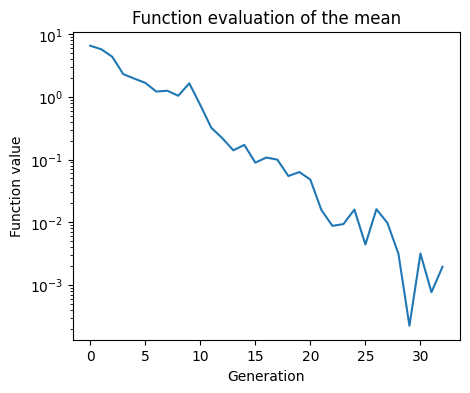

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
#ax.plot(res) 
ax.semilogy(res)
ax.set_title('Function evaluation of the mean')
ax.set_xlabel('Generation')
ax.set_ylabel('Function value')
plt.show()

In [7]:
xm

Array([2.999589, 1.001535], dtype=float32)